# PROJETO ANÁLISE PREDITIVA - CONSUMO ENERGIA ELÉTRICA

O objetivo dessa análise preditiva é identificar os grupos de consumidores com a técnica de aprendizagem não supervisionada, ou seja, identificar os clusters presentes no dataset. Este é um projeto prático feito ao longo do curso Data Science Academy e que foi aperfeiçoado antes da publicação no GitHub. 

Temos um dataset com o consumo de energia elétrica dos últimos 4 anos no nível doméstico. 
A fonte dos dados é: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

## 1 - Carga de Pacotes

Nesta seção será carregados todos os pacotes necessários para a execução do script em Python.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 2 - Carga dos Dados

Nesta seção será feita a carga dos dados disponibilizados pelo UCI.

In [2]:
# Carregando os dados
bd_power_consumption = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)
bd_power_consumption.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## 3 - Análise Explorátoria

Seção destinada a uma breve análise exploratória dos dados para um melhor entedimento relacionado a relação das variáveis.

In [3]:
# Verifica os tipos de dados
# Dados estão como Object, como será feito o uso do PCA não é necessário alterara o tipo ao menos nesse momento da análise
bd_power_consumption.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [4]:
# Verifica o shape da base
# Confirma que todos os dados foram carredados
bd_power_consumption.shape

(2075259, 9)

In [5]:
# Verifica se há valores nulos
bd_power_consumption.isnull().values.any()

True

In [6]:
# Contagem de valores nulos

print("Ao todos temos um total de ",bd_power_consumption.isnull().values.sum())
print("Isso corresponde a ", round((bd_power_consumption.isnull().values.sum()/bd_power_consumption.shape[0])*100,1),"%")
print("Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.")

Ao todos temos um total de  25979
Isso corresponde a  1.3 %
Os registros nulos representam apenas 1% da base, dessa forma será melhor removê-los da base.


In [7]:
# Remove registros nulos da base
# Pelo número de linas, confirmamos que houve a remoção dos valores nulos
bd_power_consumption.dropna()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [8]:
# Para análise com séries temporais do Pandas será necessário converter a coluna Date em DateTime
# Primeiro vamos copiar o dataset original para preservar os dados

bd_analise = bd_power_consumption
bd_analise.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [9]:
# Alguns valores na base estão como "?" e neste caso vamos substituir por 0
bd_analise = bd_analise.replace(to_replace = ['?'], value = [0])

In [10]:
# Conversão da coluna Date para DateTime e demais colunas para tipo numérico
# Confirma pelo tipo de dados
bd_analise['Date'] = pd.to_datetime(bd_analise["Date"])
bd_analise['Global_active_power'] = pd.to_numeric(bd_analise['Global_active_power'])
bd_analise['Global_reactive_power'] = pd.to_numeric(bd_analise['Global_reactive_power'])
bd_analise['Voltage'] = pd.to_numeric(bd_analise['Voltage'])
bd_analise['Global_intensity'] = pd.to_numeric(bd_analise['Global_intensity'])
bd_analise['Sub_metering_1'] = pd.to_numeric(bd_analise['Sub_metering_1'])
bd_analise['Sub_metering_2'] = pd.to_numeric(bd_analise['Sub_metering_2'])
bd_analise['Sub_metering_3'] = pd.to_numeric(bd_analise['Sub_metering_3'])

bd_analise.dtypes

Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

In [11]:
bd_analise.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [12]:
# Cria coluna com Ano e Mês para análise de séries temporais
bd_analise['Year'] = pd.DatetimeIndex(bd_analise['Date']).year
bd_analise['Month'] = pd.DatetimeIndex(bd_analise['Date']).month
bd_analise.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Month
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12


In [23]:
# Agrupamento dos dados da análise exploratória por ano
bd_plot = bd_analise.groupby('Year', as_index = False).mean()
bd_plot

,Year,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month
0,2006,1.900949,0.131362,241.397219,8.028496,1.248409,2.214584,7.409558,12.000000
1,2007,1.108653,0.116487,237.593523,4.728866,1.222504,1.625495,5.794556,6.526027
2,2008,1.071822,0.117079,240.564793,4.550809,1.109563,1.255891,6.033701,6.513661
3,2009,1.069854,0.130338,239.924570,4.517932,1.127582,1.126608,6.822712,6.526027
4,2010,1.021624,0.124624,232.552429,4.312222,0.950872,1.060810,7.244024,6.155771


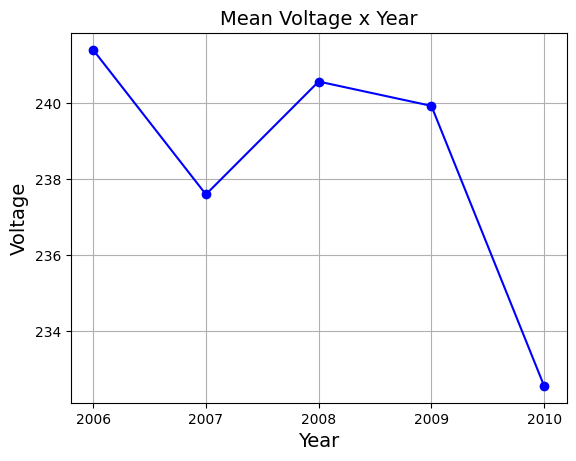

In [45]:
# Gráfico de linhas para análise do comportamento do consumo médio ao longo dos anos

plt.plot(bd_plot['Year'], bd_plot['Voltage'], color='blue', marker='o')
plt.title('Mean Voltage x Year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Voltage', fontsize=14)
plt.xticks(range(2006,2011))
plt.grid(True)
plt.show()

O uso médio da voltagem a cada ano sem mantém em torno de 239 em média, porém em 2010 temos uma queda acentuada. Talvez seja uma mudança de comportamento em função da redução de custo do próprio consumidor porque ao analisar desde 2008 vemos uma queda constante nesse indicador.

In [ ]:
# Draw Plot
sns.boxplot(x='Year', y='Voltage', data=bd_analise, ax=axes[0])

# 4 - Pré-Processamento dos Dados

Seção destinada ao Pré-Processamento dos dados, como uso de PCA e normalização dos dados.

In [ ]:
# Obtém os valores dos atributos 
dataset_atrib = dataset.values
dataset_atrib

In [ ]:
# Coleta uma amostra de 5% dos dados para não comprometer a memória do computador
amostra1, amostra2 = train_test_split(dataset_atrib, train_size = .05)
amostra1.shape

In [ ]:
# Aplica redução de dimensionalidade
pca = PCA(n_components = 2).fit_transform(amostra1)

In [ ]:
# Determinando um range de K
k_range = range(1,12)

In [ ]:
# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [ ]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [ ]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [ ]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [ ]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [ ]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

In [ ]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

# 5 - Modelo Preditivo v1.0

Aplicação do modelo preditivo para identificação dos clusters

In [ ]:
# Criando um modelo com K = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

In [ ]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 6 - Análise dos Resultados do Modelo v1.0

In [ ]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [ ]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

# 7 - Modelo Preditivo v2.0

Nesta seção será feito o modelo com um K = 10 para avaliação resultado do modelo preditivo

In [ ]:
# Criando um modelo com K = 10
modelo_v2 = KMeans(n_clusters = 10)
modelo_v2.fit(pca)

In [ ]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 8 - Análise dos Resultados do Modelo v2.0

In [ ]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [ ]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v2.cluster_centers_
inert = modelo_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

In [ ]:
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [ ]:
# Cria o cluster map
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [ ]:
cluster_map

In [ ]:
# Calcula a média de consumo de energia por cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

# 9 - Conclusão da Análise